                                                                                            Martin Donachie
                                                                                            University of Auckland, NZ
                                                                                            mdon849@aucklanduni.ac.nz
# MAF Primer -- draft version

## Overview

The [Metrics Analysis Framework](https://www.lsst.org/scientists/simulations/maf) (MAF) is a toolbox of Python-based software designed to be used with the simulated survey data generated by the [Operations Simulator](https://www.lsst.org/scientists/simulations/opsim) (OpSim). The tools are designed to allow easy customisation and extension in order to adapt to the specific needs of the various science collaborations working with LSST.

This primer aims to outline the fundamental building blocks of MAF and demonstrate some common usage cases, followed by some microlensing specific examples.

## Background

OpSim produces simulated LSST observations over a full ten-years of operation. The simulator includes multiple inputs which automatically adapt and inform observations in real-time. These include: observation parameters required by the various science cases; a model of the telescope, dome and instrumentation; sophisticated weather and enviroment models, and a downtime handler.

The output from OpSim is a database detailing the pointing history, atmospheric conditions and image characterstics over the course of the simulated survey.

The current "baseline" observing strategy is the OpSim run named *"minion_1016"*. However, a selection of additional simulated surveys, using different observing strategies and cadences, have also been carried out. MAF provides a framework for comparing these competing surveys, with the aim being to produce a concise set of figures quantifying the science returns for a given observing strategy.

Thus, the ultimate goal of MAF is to inform the final observing strategy and cadence, ensuring maximal science returns from LSST.

## Installation

### LSST Science Pipelines

The documentation pages on the LSST Science Pipelines site provide a detailed [installation guide](https://pipelines.lsst.io/install/index.html#installing-the-lsst-science-pipelines).

The Pipelines can be installed as an [Anaconda/Miniconda](https://pipelines.lsst.io/install/conda.html) binary package or built from [source](https://pipelines.lsst.io/install/newinstall.html). (Conda installation takes **~15-20 mins**; full source install takes **~2-3 hours**.)

However, if you just wish to install the simulation packages required to run this notebook, go to the source install instructions and complete steps **1-3 only**, then follow the MAF installation instructions in the next section. (Do not run *step 4: "Install Packages"* -- the required simulation packages are included in the MAF installation detailed below. Only run step 4 if you wish to do a full source install.)

If you do a full source install or Conda install, you may wish to download and run the short [demo](https://pipelines.lsst.io/install/demo.html) provided to quickly test that the Pipelines have been installed successfully.

*Note: The Anaconda/Miniconda installation requires **Python 2**. Experimental **Python 3** support is only available via source installation.*

### MAF

MAF is included as part of the LSST Simulation Framework software, which can installed by following [this guide](https://confluence.lsstcorp.org/display/SIM/Catalogs+and+MAF). MAF installation can only be done from source as the Conda binary installation is no longer supported. (Source install takes **~2 hours** to complete from scratch; however, if you have done a full source install of the science pipelines, you will already have most of the required packages -- therefore this step will only require an additional **~15-20 mins**.)

After installation, setup MAF in a new terminal by entering:

```
source $LSST_INSTALL_DIR/loadLSST.bash
setup sims_maf -t sims
```
(Using whatever file extension is appropriate for your shell -- e.g. ".csh", ".ksh", etc.)

Check the package has been setup correctly by running:

```
eups list -v sims_maf
```
This should display details of the package location and version number. (EUPS: Extended Unix Product System, is a package manager used for LSST software.)

MAF will have to be setup **before** running Jupyter Notebook in order for the following code to work. If this is your first time running this notebook you may need to setup MAF and then restart.

### OpSim Runs

A Summary Table describing the data fields contained in each of the OpSim databases can be found [here](https://www.lsst.org/scientists/simulations/opsim/summary-table-column-descriptions-v335).

The current set of benchmark surveys are available [here](https://www.lsst.org/scientists/simulations/opsim/opsim-v335-benchmark-surveys).

The full selection of available OpSim runs can be found [here](http://ops2.tuc.noao.edu/runs/).

Download the desired OpSim survey(s) (*"minion_1016"*, is the default run used in this demo) and place them in a separate directory from the LSST stack (e.g. '~/LSST/opsim-data/').

## Introduction to MAF

The goal of MAF is to provide a framework for quantifying the science and visualising the properties of competing observing strategies. MAF has been designed to meet a specific set of requirements, namely:

1. Read in the OpSim survey data
2. Separate the data into subsets according to a range of criteria
3. Apply various algorithms to each subset
4. Save and visualise the results

The key components of MAF are the `Metric,` `Slicer` and `Database` classes. 

The `Database` class contains the OpSim run to be analysed. This can be refined using SQL constraints before the data is passed to the `Slicer`. 

The `Slicer` class is used to slice the the database into smaller subsets before being passed to the chosen metric(s).

The `Metric` class contains various algorithms which return some value for each slice of data.

Depending on the specific slicer chosen, MAF may return: a single metric value calculated over the entire survey; a metric value at each point on the sky or at some fixed pointing as a function of time; or a value calculated only over a subset of visits which meet specific criteria.

The following sections will introduce some of the common slicers and metrics available in MAF, and demonstrate their applications with some basic examples.

### Preamble

Typically the preamble will remain much the same. You may wish to add or remove certain modules depending on what exactly is being done, but the ones listed below are the most commonly used.

In [2]:
# Import numpy and matplotlib
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Import required dependencies from LSST stack
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots

In [3]:
# Define the OpSim run to be analysed
runName = 'minion_1016'

# Define where the db file is located
opsimDir = '/home/mdon849/LSST/opsim-data/'

opsdb = db.OpsimDatabase(opsimDir + runName + '_sqlite.db')
print 'Selected OpSim database: ' + opsdb.database

# Define where the MAF output should be saved
outDir = 'output-mafprimer'
resultsDb =  db.ResultsDb(outDir=outDir)

Selected OpSim database: /home/mdon849/LSST/opsim-data/minion_1016_sqlite.db


## Inputs

### SQL Constraints

SQL constraints can be applied to the database before it is passed to the `Slicer` and `Metric`. These can be used to restrict analysis to certain passbands, a specific part of the time series, etc.

In [4]:
# Query <n> years of database
nyears = 2

# Select all bands
sqlconstraint = 'night < %i' % (365.25 * nyears)
# Select R band
sqlconstraintR = 'filter = "r" and night < %i' % (365.25 * nyears)
# Select I band
sqlconstraintI = 'filter = "i" and night < %i' % (365.25 * nyears)

### Slicers

- `UniSlicer:` returns a single slice containing all visits in the `Database`.

- `OneDSlicer:` returns slices of data where the value of the user-specified column is within a given interval.

- `HealpixSlicer:` returns slices of data where the RA/Dec of visits overlap with HEALpix grid points.

- `OpsimFieldSlicer:` returns slices of data matching OpSim FieldIDs.

- `UserPointsSlicer:` evaluates pointings overlapping a user-specified list of RA/Dec points.

*Note: HEALpix = Hierarchical Equal Area isoLatitude Pixelisation*

Now lets's define the slicers to be used.

In [45]:
# Define the required slicers
slicer1 = slicers.UniSlicer()
slicer2 = slicers.OneDSlicer(sliceColName='night', bins=100)
slicer3 = slicers.HealpixSlicer(nside=64) # nside defines resolution of slicer; default=128, can be set to any power of 2.
slicer4 = slicers.OpsimFieldSlicer()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


### Metrics

There are a wide variety of predefined metrics in MAF. Each of these can be easily combined to construct new, more complex, metrics. These include common statistical metrics:

- `MaxMetric`, `MinMetric`, `MedianMetric`, `MeanMetric`, `RmsMetric`

count metrics:

- `CountMetric`, `AccumulateCountMetric`

as well more advanced metrics:

- `AveGapMetric`, `InterNightGapsMetric`, `IntraNightGapsMetric`, `TransientMetric`, `StarDensityMetric`

Some of these metrics will be demonstrated below.

A `MetricBundle` is a class of object which combines a `Metric`, `Slicer` and SQL constraint. After it has been run, the `MetricBundle` contains the metric value for each slice in the data.

Multiple `MetricBundles` can be packaged up into a dictionary before being run on the `Database` simultaneously as a `MetricBundleGroup`. This is an efficient way of calculating multiple metrics. Metrics using different slicers can also be packaged into the same `MetricBundleGroup`; MAF will separate these out and complete one full pass of the `Database` for each `Slicer`, calculating all of the relevant metrics, before completing another pass with the next `Slicer` in the `MetricBundleGroup` and returning those metric values.

Firstly, let's prepare a basic MetricBundle using the UniSlicer.

In [46]:
# CountMetric will return the no. of instances passed from the slicer (column kwarg is irrelevant, any column name will work)
countmetric = metrics.CountMetric('expMJD')

# The total no. of visits is calculated by slicing over the whole dataset via UniSlicer
totvisits = metricBundles.MetricBundle(countmetric, slicer1)
# Find the no. of visits in one band by adding a SQL constraint
totvisitsR = metricBundles.MetricBundle(countmetric, slicer1, sqlconstraint='filter = "r"')
totvisitsI = metricBundles.MetricBundle(countmetric, slicer1, sqlconstraint='filter = "i"')

bundleDict1 = {'totvisits':totvisits, 'totvisitsR':totvisitsR, 'totvisitsI':totvisitsI}

Now, let's prepare a second MetricBundle using the HealpixSlicer.

In [48]:
# The plotting characterstics can be manually set using plotDict
#plotDict = {'xMin':0, 'xMax':1.2, 'colorMin':0, 'colorMax':1.2, 'binsize':0.025} 
# Select desired output plots for HealpixSlicer (by default plotAll will produce a SkyMap, Histogram and PowerSpectrum)
plotFuncs = [plots.HealpixSkyMap(), plots.HealpixHistogram()]

# Calculate the no. of visits per healpix in all bands
nvisits = metricBundles.MetricBundle(countmetric, slicer3, plotFuncs=plotFuncs)
# Calculate the no. of visits per healpix in R/I bands
nvisitsR = metricBundles.MetricBundle(countmetric, slicer3, sqlconstraint='filter = "r"', plotFuncs=plotFuncs)
nvisitsI = metricBundles.MetricBundle(countmetric, slicer3, sqlconstraint='filter = "i"', plotFuncs=plotFuncs)

bundleDict2 = {'nvisits':nvisits, 'nvisitsR':nvisitsR, 'nvisitsI':nvisitsI}

An example usage of the OneDSlicer would be measuring the median seeing over the duration of the survey.

In [49]:
# Define metric to calculate median PSF
medianmetric = metrics.MedianMetric('FWHMeff')

# Slice dataset by night and calculate median PSF for R/I bands
medseeingR = metricBundles.MetricBundle(medianmetric, slicer2, sqlconstraint='filter = "r"')
medseeingI = metricBundles.MetricBundle(medianmetric, slicer2, sqlconstraint='filter = "i"')

bundleDict3 = {'medseeingR':medseeingR, 'medseeingI':medseeingI}

Let's prepare one final MetricBundle to measure the maximum airmass for each OpSim field.

In [51]:
# Define metric to calculate maximum airmass
maxmetric = metrics.MaxMetric('airmass')

# Slice dataset by OpsimField and calculate maximum airmass for R/I bands
maxairmassR = metricBundles.MetricBundle(maxmetric, slicer4, sqlconstraint='filter = "r"')
maxairmassI = metricBundles.MetricBundle(maxmetric, slicer4, sqlconstraint='filter = "i"')

bundleDict4 = {'maxairmassR':maxairmassR,'maxairmassI':maxairmassI}

## Output

Now run the analysis for each MetricBundleGroup.

In [52]:
group1 = metricBundles.MetricBundleGroup(bundleDict1, opsdb, outDir=outDir, resultsDb=resultsDb)
group1.runAll()

group2 = metricBundles.MetricBundleGroup(bundleDict2, opsdb, outDir=outDir, resultsDb=resultsDb)
group2.runAll()

group3 = metricBundles.MetricBundleGroup(bundleDict3, opsdb, outDir=outDir, resultsDb=resultsDb)
group3.runAll()

group4 = metricBundles.MetricBundleGroup(bundleDict4, opsdb, outDir=outDir, resultsDb=resultsDb)
group4.runAll()

Querying database with no constraint.
Found 2447931 visits
Running:  ['totvisits']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint filter = "i"
Found 541688 visits
Running:  ['totvisitsI']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint filter = "r"
Found 538713 visits
Running:  ['totvisitsR']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with no constraint.
Found 2447931 visits
Running:  ['nvisits']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint filter = "i"
Found 541688 visits
Running:  ['nvisitsI']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint filter = "r"
Found 538713 visits
Running:  ['nvisitsR']
Completed me

/home/mdon849/LSST/lsst-stack/Linux64/sims_maf/2.3.5.sims+2/python/lsst/sims/maf/slicers/opsimFieldSlicer.py:91: UserWarning: Warning: this OpsimFieldSlicer was already set up once. Re-setting up an OpsimFieldSlicer can change the field information. Rerun metrics if this was intentional. 
  warnings.warn(warning_msg)


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint filter = "r"
Found 538713 visits
Running:  ['maxairmassR']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


The results are contained in the metricValues attribute of each object.

In [107]:
print 'Total no. of visits: ' + str(totvisits.metricValues[0]) + '\n' \
'R band visits: ' + str(totvisitsR.metricValues[0]) + '\n' \
'I band visits: ' + str(totvisitsI.metricValues[0])

Total no. of visits: 2447931.0
R band visits: 538713.0
I band visits: 541688.0


Metric values for the objects run with HealpixSlicer, OneDSlicer and OpSimFieldSlicer can be returned in a similar way, however, for these slicers it is much more useful to visualise the outputs.

Plotting figures with "" constraint now.
Plotting complete.
Plotting figures with "filter = "i"" constraint now.
Plotting complete.
Plotting figures with "filter = "r"" constraint now.
Plotting complete.


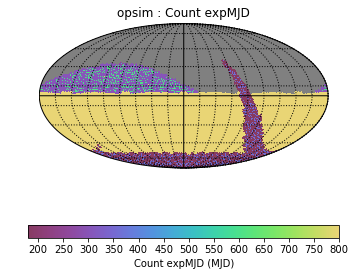

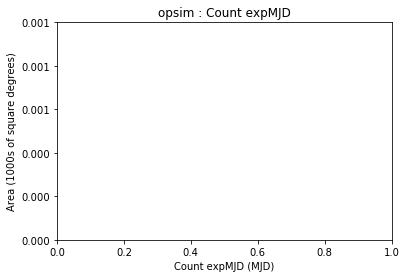

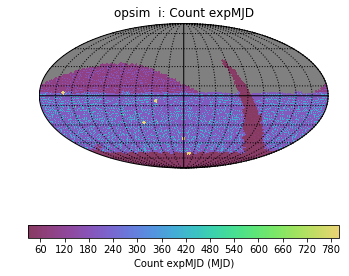

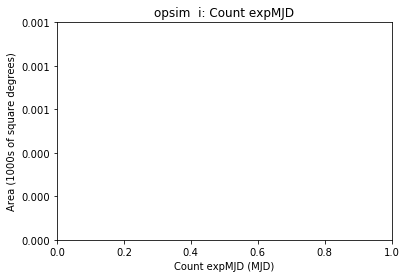

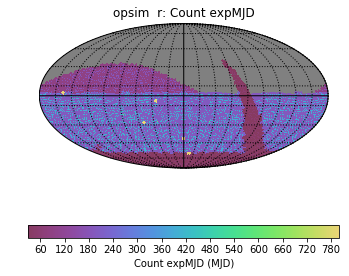

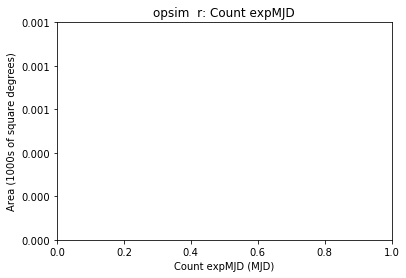

In [108]:
# Plot all metrics in MetricBundleGroup (SkyMap, Histogram and PowerSpectrum are HealpixSlicer defaults; otherwise return desired plots as set via plotFuncs)
group2.plotAll(closefigs=False) slicers.

Individual plots can be customised without having to re-run the analysis. Let's change the colour scaling on the SkyMap to make them clearer.

{'SkyMap': 3}

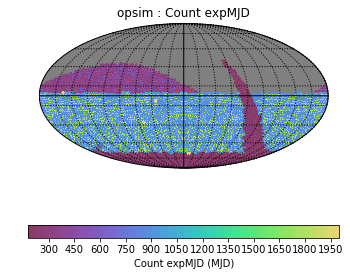

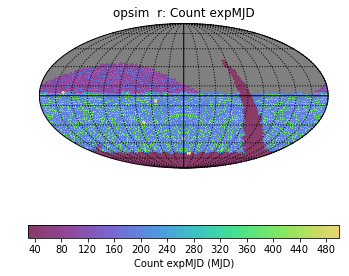

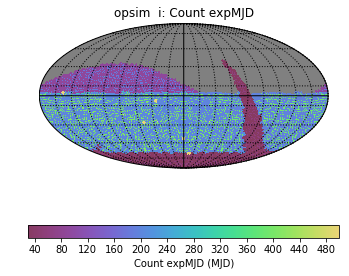

In [121]:
nvisits.setPlotDict({'colorMax':2000})
nvisits.setPlotFuncs({plots.HealpixSkyMap()})
nvisits.plot()

nvisitsR.setPlotDict({'colorMax':500})
nvisitsR.setPlotFuncs({plots.HealpixSkyMap()})
nvisitsR.plot()

nvisitsI.setPlotDict({'colorMax':500})
nvisitsI.setPlotFuncs({plots.HealpixSkyMap()})
nvisitsI.plot()

Plotting figures with "filter = "i"" constraint now.
Plotting complete.
Plotting figures with "filter = "r"" constraint now.
Plotting complete.


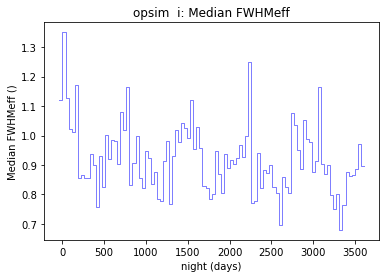

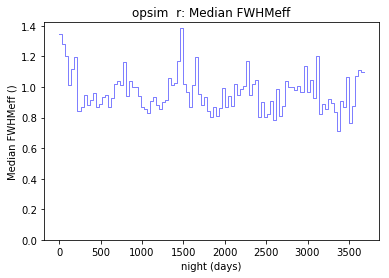

In [122]:
# Plot all metrics in MetricBundleGroup (OneDSlicer)
group3.plotAll(closefigs=False)

Plotting figures with "filter = "i"" constraint now.


/home/mdon849/LSST/lsst-stack/Linux64/sims_maf/2.3.5.sims+2/python/lsst/sims/maf/plots/spatialPlotters.py:602: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(plotDict['bgcolor'])


Plotting complete.
Plotting figures with "filter = "r"" constraint now.
Plotting complete.


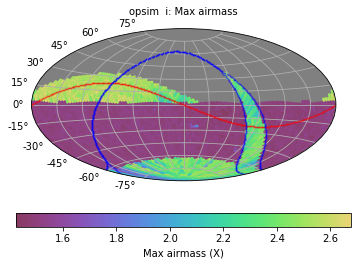

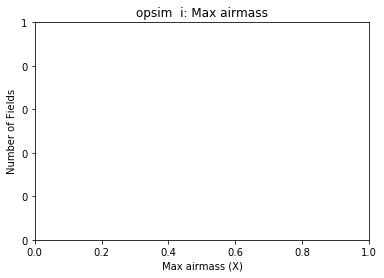

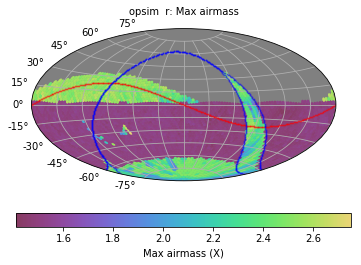

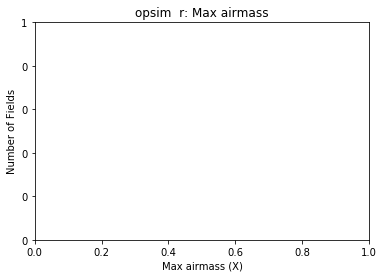

In [53]:
# Plot all metrics in MetricBundleGroup (OpsimFieldSlicer)
group4.plotAll(closefigs=False)

## Useful Metrics

### Time Gaps



In [134]:
slicer = slicers.HealpixSlicer(nside=32)

m1 = metrics.IntraNightGapsMetric()
m2 = metrics.InterNightGapsMetric()
m3 = metrics.AveGapMetric()

# metrics.TgapsMetric

plotFuncs = [plots.HealpixSkyMap(), plots.HealpixHistogram()]

intrangp = metricBundles.MetricBundle(m1, slicer, sqlconstraint='filter = "r"', plotFuncs=plotFuncs)
interngp = metricBundles.MetricBundle(m2, slicer, sqlconstraint='filter = "r"', plotFuncs=plotFuncs)
avegp = metricBundles.MetricBundle(m3, slicer, sqlconstraint='filter = "r"', plotFuncs=plotFuncs)

bundleDict = {'intrangp':intrangp, 'interngp':interngp, 'avegp':avegp}

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


In [135]:
timegaps = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
timegaps.runAll()

Querying database with constraint filter = "r"
Found 538713 visits
Running:  ['interngp', 'avegp', 'intrangp']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "filter = "r"" constraint now.


/home/mdon849/LSST/lsst-stack/Linux64/sims_maf/2.3.5.sims+2/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 1201 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


Plotting complete.


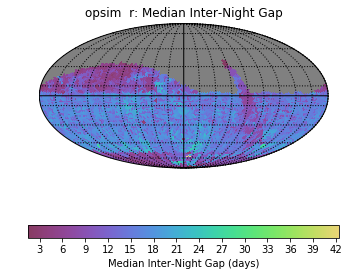

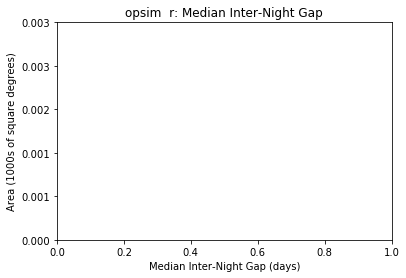

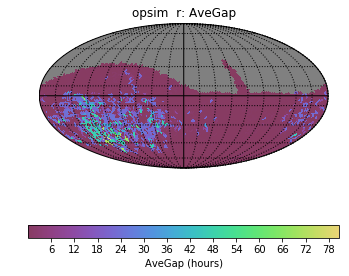

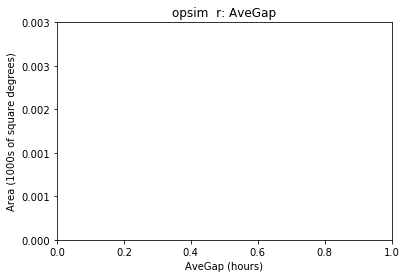

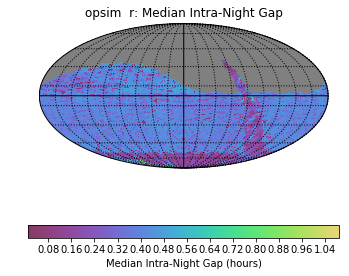

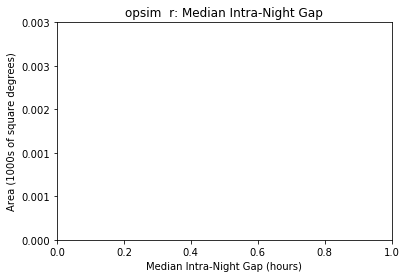

In [136]:
timegaps.plotAll(closefigs=False)

### Transients

The TransientMetric allows you to quickly and easily mock-up a template light curve, and calculate the fraction of events with the chosen signature which would be detected. A specific transient model can also be substituted in place of the template before running the analysis.

The help file below lists the available parameters for customising the template.

In [139]:
help(metrics.TransientMetric)

Help on class TransientMetric in module lsst.sims.maf.metrics.transientMetrics:

class TransientMetric(lsst.sims.maf.metrics.baseMetric.BaseMetric)
 |  Calculate what fraction of the transients would be detected. Best paired with a spatial slicer.
 |  We are assuming simple light curves with no color evolution.
 |  
 |  Parameters
 |  ----------
 |  transDuration : float, optional
 |      How long the transient lasts (days). Default 10.
 |  peakTime : float, optional
 |      How long it takes to reach the peak magnitude (days). Default 5.
 |  riseSlope : float, optional
 |      Slope of the light curve before peak time (mags/day).
 |      This should be negative since mags are backwards (magnitudes decrease towards brighter fluxes).
 |      Default 0.
 |  declineSlope : float, optional
 |      Slope of the light curve after peak time (mags/day).
 |      This should be positive since mags are backwards. Default 0.
 |  uPeak : float, optional
 |      Peak magnitude in u band. Default 20.

In [37]:
slicer = slicers.HealpixSlicer(nside=16)

# Define specific peak magnitudes for each band if required
#peaks = {'uPeak':18, 'gPeak':19, 'rPeak':20, 'iPeak':21, 'zPeak':22,'yPeak':23}

# Define metrics with different requirements and/or light curve properties
metric1 = metrics.TransientMetric(riseSlope=-2.0, declineSlope=2.0, transDuration=21.0, peakTime=10.5, nPrePeak=1) # **peaks
metric2 = metrics.TransientMetric(riseSlope=-2.0, declineSlope=2.0, transDuration=21.0, peakTime=10.5, nPrePeak=2)

plotFuncs = [plots.HealpixSkyMap()]


frctrans_1pt = metricBundles.MetricBundle(metric1, slicer, sqlconstraint='', plotFuncs=plotFuncs)
frctrans_2pt = metricBundles.MetricBundle(metric2, slicer, sqlconstraint='', plotFuncs=plotFuncs)

bundleDict = {'frctrans_1pt':frctrans_1pt, 'frctrans_2pt':frctrans_2pt}

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


/home/mdon849/LSST/lsst-stack/Linux64/sims_maf/2.3.5.sims+2/python/lsst/sims/maf/metricBundles/metricBundle.py:64: UserWarning: Future warning - "sqlconstraint" will be deprecated in favor of "constraint" in a future release.
  warnings.warn('Future warning - "sqlconstraint" will be deprecated in favor of '


In [38]:
transgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
transgroup.runAll()

Querying database with no constraint.
Found 2447931 visits
Running:  ['frctrans_2pt', 'frctrans_1pt']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "" constraint now.
Plotting complete.


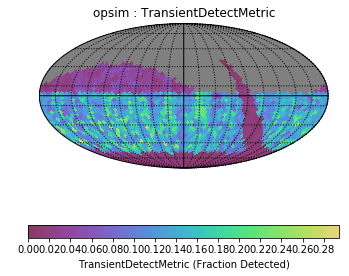

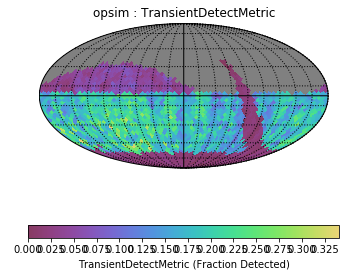

In [39]:
transgroup.plotAll(closefigs=False)

Plots show a higher detection fraction when only 1 point is required prior to the peak, as expected.

## TBC

- metrics.starDensity
- metrics.starCounts
- microlensing rate